In [4]:
import os

import numpy as np
from pandas import Series,DataFrame
import pandas as pd
%pylab inline
# pd.set_option('display.max_rows', 10)
# pd.set_option('display.notebook_repr_html', True)
# pd.set_option('display.max_columns', 20)

import seaborn as sns
import colorsys
import statsmodels.api as sm
import statsmodels.formula.api as smf

from sklearn import linear_model
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

Populating the interactive namespace from numpy and matplotlib


C:\Users\Jushira Thelakkat\Anaconda2\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


### Read in data

In [5]:
df = pd.read_csv('shot_logs.csv')
playerstats = pd.read_csv('players_stats.csv')

### Initial Data Cleaning - Remove NaN!

In [ ]:
print df.shape
print playerstats.shape

In [ ]:
df.dropna(inplace = True) #Drop NaN

In [ ]:
df.shape

In [ ]:
playerstats.dropna(inplace = True)

In [ ]:
playerstats.shape

In [ ]:
print 'Number of observations dropped in shotlogs',128069-122502
print 'Dataset has 122502 rows and 21 columns out of which we drop 5567 rows because of NaN values!'

### Split data into 2 points and 3 points

In [ ]:
df.PTS_TYPE.value_counts()

In [ ]:
two_df= df[df['PTS_TYPE']==2]
three_df= df[df['PTS_TYPE']==3]
print 'The percentage of shots that are 2 points:', (float(two_df.shape[0])/(two_df.shape[0]+three_df.shape[0]))*100, '%'
print 'The percentage of shots that are 3 points:', (float(three_df.shape[0])/(three_df.shape[0]+two_df.shape[0]))*100, '%'
print 'Dimensions of 2-pts dataset:', two_df.shape
print 'Dimensions of 3-pts dataset:', three_df.shape

### Splitting 2 points dataset into training and test data!

In [ ]:
train_2_df = two_df.sample(frac = .6, random_state = 0)
test_2_df = two_df.drop(train_2_df.index)

In [ ]:
print 'Dimensions of 2-pts training set:' , train_2_df.shape  # 0.6 of the 2 pts dataset!
print 'Dimensions of 2-pts test set:' , test_2_df.shape

### Data Exploration of dataset

To build our model, we will use only our 2-pts training dataset from now on.

In [ ]:
train_2_df.describe()

In [ ]:
train_2_df.FGM.value_counts()

In [ ]:
train_2_df.FGM.value_counts()[1]/float(train_2_df.shape[0])

The overall field goal percentage is roughly 49% in the 2-point training set. 

In [ ]:
color = train_2_df.FGM.map(pd.Series({0: 'red', 1: 'green'}))
color

In [ ]:
GameID_count = pd.value_counts(train_2_df.GAME_ID).to_frame().reset_index()
GameID_count.columns = ['ID', 'count']
GameID_count['ID'].count()

The trainingset contains 896 games.

In [ ]:
GameID_count1 = pd.value_counts(test_2_df.GAME_ID).to_frame().reset_index()
GameID_count1.columns = ['ID', 'count']
GameID_count1['ID'].count()

GAMES/SHOTS DISTRIBUTION BY MONTH

In [34]:
#Variable transformation
def mu_transform(mu):
    mu = mu.split(",")
    mu=mu[0]
    mu = mu.split(' ')
    mu_t=mu[0]
    return mu_t

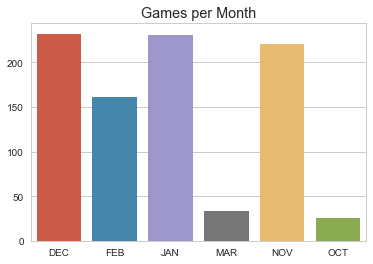

In [35]:
df['Month']= df.MATCHUP.apply(mu_transform)
# g = pd.value_counts(df['Month']).to_frame().reset_index()
# g.columns = ['Month', 'count']
# g = pd.value_counts(df['Month']).to_frame().reset_index()
# g.columns = ['Month_', 'count']

games_month=df.groupby('Month')['GAME_ID'].nunique().to_frame().reset_index()
games_month.columns = ['Month', 'Number of games']
# plot(games_month,kind='bar')
# g.columns = ['Month_', 'count']

def graph(graph_title):

    sns.set_style("whitegrid")
    ax = sns.barplot(y = 'Number of games', x = 'Month', data=games_month)
    ax.set(xlabel = '', ylabel = '', title = graph_title)
    ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
graph('Games per Month')



- October has less number of games. Expected since the season starts at the end of the month.
- November, December and January have the highest games.
- February sees a drop in games because there is a weeklong break.
- Least games played in March and October as they are the beginning and end months of the season.

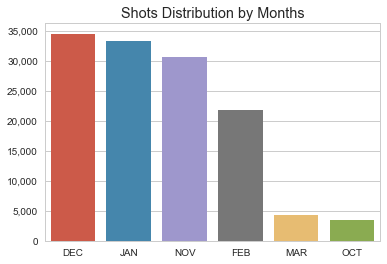

In [36]:
df['Month']= df.MATCHUP.apply(mu_transform)
g = pd.value_counts(df['Month']).to_frame().reset_index()
g.columns = ['Month', 'count']
g = pd.value_counts(df['Month']).to_frame().reset_index()
g.columns = ['Month_', 'count']

def graph(graph_title):

    sns.set_style("whitegrid")
    ax = sns.barplot(y = 'count', x = 'Month_', data=g)
    ax.set(xlabel = '', ylabel = '', title = graph_title)
    ax.get_yaxis().set_major_formatter(
    matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ',')))
    _ = ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
    
graph('Shots Distribution by Months')


- October has less shots. Expected since the season starts at the end of the month.
- November, December and January have the highest shots.
- February sees a drop in shots because there is a weeklong break.
- Least in March and October as they are the beginning and end months of the season.

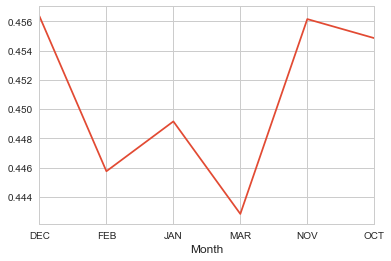

In [39]:
df.groupby('Month')['FGM'].mean().plot()

 This graph represents Field goal percentage by months. FG% is highest in November and December while lowest in March.
 This probably shows that as the season progresses, #Incomplete

SHOT DISTRIBUTION BY LOCATION

In [42]:
#transforming location variable
df['location_t'] = 0
df.at[df['LOCATION'] == 'A','location_t'] = 1

df['LOCATION'].value_counts()

A    64135
H    63934
Name: LOCATION, dtype: int64

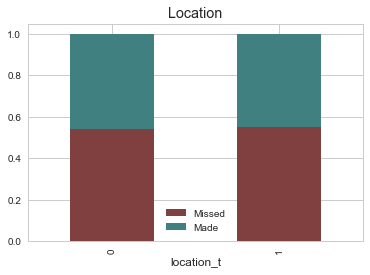

In [43]:
df_graph = pd.crosstab(df.location_t,df.FGM).apply(lambda r: r/r.sum(), axis=1)
N = len(df.location_t.value_counts().index)
HSV_tuples = [(x*1.0/N, 0.5, 0.5) for x in range(N)]
RGB_tuples = list(map(lambda x: colorsys.hsv_to_rgb(*x), HSV_tuples))
ax1 = df_graph.plot(kind="bar", stacked=True, color=RGB_tuples, title="Location")
lines, labels = ax1.get_legend_handles_labels()
ax1.legend(lines,["Missed", "Made"], loc='best')